In [1]:
import os
import pandas as pd
from pathlib import Path
import kagglehub

from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
path_to_dataset1 = kagglehub.dataset_download("tombackert/brain-tumor-mri-data")
path_to_dataset2 = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset 1:", path_to_dataset1)
print("Path to dataset 2:", path_to_dataset2)

def extract_file_paths_and_labels(dataset_path):
    file_paths = []
    labels = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith((".jpg", ".png", ".jpeg")):  # Add other image formats if needed
                file_paths.append(os.path.join(root, file))
                labels.append(os.path.basename(root))  # Use folder name as label
    return file_paths, labels

file_paths1, labels1 = extract_file_paths_and_labels(path_to_dataset1)
file_paths2, labels2 = extract_file_paths_and_labels(path_to_dataset2)

all_file_paths = file_paths1 + file_paths2
all_labels = labels1 + labels2

df_5_9 = pd.DataFrame({
    "file_path": all_file_paths,
    "label": all_labels
})

print("Combined DataFrame:")
print(df_5_9.head())

output_csv_path = Path("combined_dataset.csv")
df_5_9.to_csv(output_csv_path, index = False)
print(f"\nDataFrame saved to: {output_csv_path}")

Path to dataset 1: C:\Users\zacha\.cache\kagglehub\datasets\tombackert\brain-tumor-mri-data\versions\1
Path to dataset 2: C:\Users\zacha\.cache\kagglehub\datasets\masoudnickparvar\brain-tumor-mri-dataset\versions\1
Combined DataFrame:
                                           file_path   label
0  C:\Users\zacha\.cache\kagglehub\datasets\tomba...  glioma
1  C:\Users\zacha\.cache\kagglehub\datasets\tomba...  glioma
2  C:\Users\zacha\.cache\kagglehub\datasets\tomba...  glioma
3  C:\Users\zacha\.cache\kagglehub\datasets\tomba...  glioma
4  C:\Users\zacha\.cache\kagglehub\datasets\tomba...  glioma

DataFrame saved to: combined_dataset.csv


In [3]:
missing_values = df_5_9.isnull().sum()
print("Missing values in each column:")
print(missing_values)

duplicate_file_paths = df_5_9.duplicated(subset = ["file_path"]).sum()
print(f"\nNumber of duplicate file paths: {duplicate_file_paths}")

duplicate_rows = df_5_9.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

label_distribution = df_5_9["label"].value_counts()
print("\nLabel distribution:")
print(label_distribution)

invalid_file_paths = df_5_9[~df_5_9["file_path"].apply(os.path.exists)]

print(f"\nNumber of invalid file paths (files that don't exist): {len(invalid_file_paths)}")
if not invalid_file_paths.empty:
    print("Invalid file paths:")
    print(invalid_file_paths)

Missing values in each column:
file_path    0
label        0
dtype: int64

Number of duplicate file paths: 0
Number of duplicate rows: 0

Label distribution:
label
notumor       4000
pituitary     3514
meningioma    3420
glioma        3242
Name: count, dtype: int64

Number of invalid file paths (files that don't exist): 0


In [4]:
def preprocess_images(df, target_size = (250, 250)):
    for idx, row in tqdm(df.iterrows(), total=len(df), desc = "Preprocessing images"):
        try:
            img_path = row["file_path"]
            img = Image.open(img_path)

            # Resize to 250x250 if not already
            if img.size != target_size:
                img = img.resize(target_size)  # Resize to 250x250
                img.save(img_path)  # Overwrite the original image

        except Exception as e:
            print(f"Error preprocessing {img_path}: {e}")

preprocess_images(df_5_9)
print("Image resizing complete.")

Preprocessing images: 100%|██████████| 14176/14176 [00:06<00:00, 2187.17it/s]

Image resizing complete.


In [14]:
def check_image_properties(df):
    results = []
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Checking images"):
        img_path = row["file_path"]
        try:
            img = Image.open(img_path)

            is_grayscale = img.mode == "L"

            is_correct_size = img.size == (250, 250)

            is_jpg = img_path.lower().endswith(".jpg")

            results.append({
                "file_path": img_path,
                "is_grayscale": is_grayscale,
                "is_correct_size": is_correct_size,
                "is_jpg": is_jpg
            })

        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            results.append({
                "file_path": img_path,
                "is_grayscale": "Error",
                "is_correct_size": "Error",
                "is_jpg": "Error"
            })

    return results

image_properties = check_image_properties(df_5_9)

for result in image_properties[:5]:
    print(f"  - Grayscale: {result['is_grayscale']}")
    print(f"  - Correct Size (250x250): {result['is_correct_size']}")
    print(f"  - .jpg Format: {result['is_jpg']}")
    print()

Checking images: 100%|██████████| 14176/14176 [00:07<00:00, 1964.32it/s]

  - Grayscale: True
  - Correct Size (250x250): True
  - .jpg Format: True

  - Grayscale: True
  - Correct Size (250x250): True
  - .jpg Format: True

  - Grayscale: True
  - Correct Size (250x250): True
  - .jpg Format: True

  - Grayscale: True
  - Correct Size (250x250): True
  - .jpg Format: True

  - Grayscale: True
  - Correct Size (250x250): True
  - .jpg Format: True



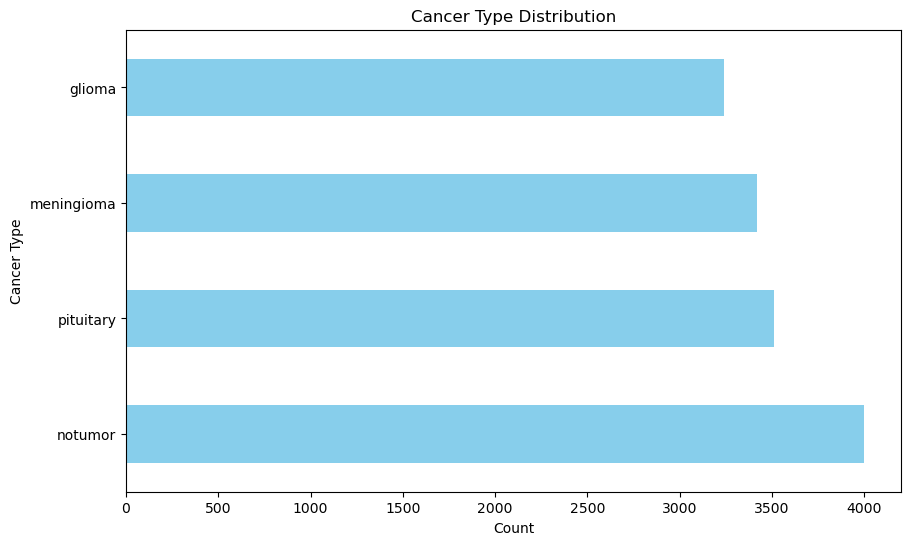


Sample images from the preprocessed dataset:


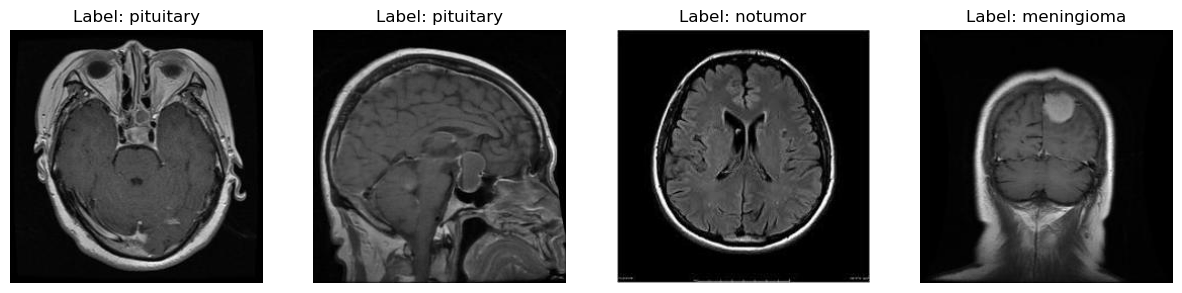

In [6]:
plt.figure(figsize = (10, 6))
label_distribution.plot(kind = "barh", title = "Cancer Type Distribution", color = "skyblue")
plt.xlabel("Count")  # Counts on the bottom (x-axis)
plt.ylabel("Cancer Type")  # Labels on the left (y-axis)
plt.show()

def display_sample_images(df, num_samples=4):
    fig, axes = plt.subplots(1, num_samples, figsize = (15, 5))
    for i, (idx, row) in enumerate(df.sample(num_samples).iterrows()):
        img = mpimg.imread(row["file_path"])
        axes[i].imshow(img, cmap = "gray")
        axes[i].set_title(f"Label: {row['label']}")
        axes[i].axis("off")
    plt.show()

print("\nSample images from the preprocessed dataset:")
display_sample_images(df_5_9)